In [3]:
import cython
import numpy as np
import TidalPy
import CyRK
print('TidalPy', TidalPy.__version__)
print('CyRK', CyRK.__version__)

TidalPy 0.5.0a5.dev17
CyRK 0.8.2a0.dev0


In [4]:
%load_ext cython

In [5]:
viscosity = 1.0e18
shear_mod = 50.0e9
comp = shear_mod**(-1)
frequency = 1.0e-6

In [25]:

float_eps = 1.0e-300
def voigt(
    frequency: 'FloatArray', compliance: 'FloatArray', viscosity: 'FloatArray',
    voigt_compliance_offset: float = 0.2, voigt_viscosity_offset: float = 0.02
    ) -> 'ComplexArray':
    """ Calculates the complex compliance utilizing the model: Voigt-Kelvin

    !TPY_args live: self.compliance, self.viscosity
    !TPY_args const: voigt_compliance_offset, voigt_viscosity_offset

    Notes
    -----
    The Voigt-Kelvin rheology is a non-realistic (except for very specific circumstances) that is generally more useful
    when comparing or building other models. It is characterized by an 'island' of dissipation in the shear modulus vs.
    viscosity phase space.

    References
    ----------
    - Henning, O'Connell, and Sasselov (2009), ApJ, DOI: 10.1088/0004-637X/707/2/1000

    Parameters
    ----------
    frequency : FloatArray
        Tidal forcing frequency [rads s-1]
        Note that a world may experience multiple tidal frequencies for NSR tides, if the eccentricity or obliquity
        is large, or for a tidal harmonic integer l > 2.
    compliance : FloatArray
        Layer or Planet's compliance (inverse of shear modulus) [Pa-1]
    viscosity : FloatArray
        Layer or Planet's effective viscosity [Pa s]
    voigt_compliance_offset : float
        Voigt component's compliance offset eta_voigt = voigt_compliance_offset * compliance
    voigt_viscosity_offset : float
        Voigt component's viscosity offset eta_voigt = voigt_viscosity_offset * viscosity

    Returns
    -------
    complex_compliance : ComplexArray
        Complex compliance (complex number) [Pa-1]
    """

    shape = 0. * (viscosity + compliance + frequency)

    voigt_comp = voigt_compliance_offset * compliance
    voigt_visc = voigt_viscosity_offset * viscosity

    denominator = (voigt_comp * voigt_visc * frequency)**2 + 1.
    denominator = (np.abs(denominator) <= float_eps) * 1.0e-100 + \
                  (np.abs(denominator) > float_eps) * denominator

    real_j = voigt_comp / denominator
    imag_j = -voigt_comp**2 * voigt_visc * frequency / denominator

    complex_compliance = real_j + \
                         ((np.abs(frequency) + shape) <= float_eps) * 0.0j + \
                         ((np.abs(frequency) + shape) > float_eps) * 1.0j * imag_j

    return complex_compliance

def maxwell(frequency: 'FloatArray', compliance: 'FloatArray', viscosity: 'FloatArray') -> 'ComplexArray':
    """ Calculates the complex compliance utilizing the model: Maxwell

    !TPY_args live: self.compliance, self.viscosity

    Notes
    -----
    The Maxwell rheology has been the traditional model used to estimate tidal dissipation in planets and moons.
    It has a characteristic peak in dissipation vs. forcing frequency. However, it has been shown that it
    underestimates dissipation at high frequencies.

    References
    ----------
    - Henning, O'Connell, and Sasselov (2009), ApJ, DOI: 10.1088/0004-637X/707/2/1000

    Parameters
    ----------
    frequency : FloatArray
        Tidal forcing frequency [rads s-1]
        Note that a world may experience multiple tidal frequencies for NSR tides, if the eccentricity or obliquity
        is large, or for a tidal harmonic integer l > 2.
    compliance : FloatArray
        Layer or Planet's compliance (inverse of shear modulus) [Pa-1]
    viscosity : FloatArray
        Layer or Planet's effective viscosity [Pa s]

    Returns
    -------
    complex_compliance : ComplexArray
        Complex compliance (complex number) [Pa-1]
    """

    shape = 0. * (viscosity + compliance + frequency)

    denominator = (viscosity * frequency)
    denominator = (np.abs(denominator) <= float_eps) * 1.0e-100 + \
                  (np.abs(denominator) > float_eps) * denominator

    real_j = compliance
    imag_j = -1.0 / denominator

    complex_compliance = real_j + \
                         ((np.abs(frequency) + shape) <= float_eps) * 0.0j + \
                         ((np.abs(frequency) + shape) > float_eps) * 1.0j * imag_j

    return complex_compliance

def burgers(
    frequency: 'FloatArray', compliance: 'FloatArray', viscosity: 'FloatArray',
    voigt_compliance_offset: float = 0.2, voigt_viscosity_offset: float = 0.02
    ) -> 'ComplexArray':
    """ Calculates the complex compliance utilizing the model: Burgers

    !TPY_args live: self.compliance, self.viscosity
    !TPY_args const: voigt_compliance_offset, voigt_viscosity_offset

    Notes
    -----
    The Burgers rheology exhibits a secondary peak in the dissipation vs. frequency domain. This peak describes a
    secondary dissipation mechanism that is dominant at this forcing frequency (grain boundary sliding, dislocation
    diffusion, etc.). It can be constructed by a linear summation of the Voigt-Kelvin and Maxwell rheologies.

    References
    ----------
    - Henning, O'Connell, and Sasselov (2009), ApJ, DOI: 10.1088/0004-637X/707/2/1000

    Parameters
    ----------
    frequency : FloatArray
        Tidal forcing frequency [rads s-1]
        Note that a world may experience multiple tidal frequencies for NSR tides, if the eccentricity or obliquity
        is large, or for a tidal harmonic integer l > 2.
    compliance : FloatArray
        Layer or Planet's compliance (inverse of shear modulus) [Pa-1]
    viscosity : FloatArray
        Layer or Planet's effective viscosity [Pa s]
    voigt_compliance_offset : float
        Voigt component's compliance offset eta_voigt = voigt_compliance_offset * compliance
    voigt_viscosity_offset : float
        Voigt component's viscosity offset eta_voigt = voigt_viscosity_offset * viscosity

    Returns
    -------
    complex_compliance : ComplexArray
        Complex compliance (complex number) [Pa-1]
    """

    voigt_complex_comp = voigt(frequency, compliance, viscosity, voigt_compliance_offset, voigt_viscosity_offset)
    maxwell_complex_comp = maxwell(frequency, compliance, viscosity)

    complex_compliance = voigt_complex_comp + maxwell_complex_comp

    return complex_compliance
from TidalPy.utilities.performance import find_factorial
def andrade(
    frequency: 'FloatArray', compliance: 'FloatArray', viscosity: 'FloatArray',
    alpha: float = 0.3, zeta: float = 1.
    ) -> 'ComplexArray':
    """ Calculates the complex compliance utilizing the model: Andrade

    !TPY_args live: self.compliance, self.viscosity
    !TPY_args const: alpha, zeta

    Notes
    -----
    The Andrade rheology is partially constructed from the Maxwell rheology. This is further modified by a term that,
    in the time-domain, is proportional to t^{\alpha}. In the Fourier domain this translates to a frequency dependence
    ~\omega^{-\alpha}. This model was originally developed for the stress-strain relationship in metals, but has been
    found to model planetary materials as well.

    This version of the model will not transition into a Maxwell-like rheology at very low frequencies.

    References
    ----------
    - Gribb and Cooper (1998), JGR, DOI: 10.1029/98JB02786
    - Efroimsky (2012), ApJ, DOI: 10.1088/0004-637X/746/2/150
    - Renaud and Henning (2018), ApJ, DOI: 10.3847/1538-4357/aab784

    Parameters
    ----------
    frequency : FloatArray
        Tidal forcing frequency [rads s-1]
        Note that a world may experience multiple tidal frequencies for NSR tides, if the eccentricity or obliquity
        is large, or for a tidal harmonic integer l > 2.
    compliance : FloatArray
        Layer or Planet's compliance (inverse of shear modulus) [Pa-1]
    viscosity : FloatArray
        Layer or Planet's effective viscosity [Pa s]
    alpha : float
        Andrade exponent parameter
    zeta : float
        Andrade timescale parameter

    Returns
    -------
    complex_compliance : ComplexArray
        Complex compliance (complex number) [Pa-1]
    """

    andrade_term = compliance * viscosity * frequency * zeta
    andrade_term = (np.abs(andrade_term) <= float_eps) * 1.0e-100 + \
                   (np.abs(andrade_term) > float_eps) * andrade_term

    const_term = compliance * andrade_term**(-alpha) * find_factorial(alpha)

    shape = 0. * (andrade_term + alpha)

    real_j = np.cos(alpha * np.pi / 2.) * const_term
    imag_j = -np.sin(alpha * np.pi / 2.) * const_term

    # If the frequency is at zero then the real value goes to +infinity. Set to large value instead. Imag -> 0.
    andrade_complex_comp = ((np.abs(frequency) + shape) <= float_eps) * (1.0e100 + 0.0j) + \
                           ((np.abs(frequency) + shape) > float_eps) * (real_j + 1.0j * imag_j)

    maxwell_complex_comp = maxwell(frequency, compliance, viscosity)

    complex_compliance = maxwell_complex_comp + andrade_complex_comp

    return complex_compliance

def sundberg(
    frequency: 'FloatArray', compliance: 'FloatArray', viscosity: 'FloatArray',
    voigt_compliance_offset: float = 0.2, voigt_viscosity_offset: float = 0.02,
    alpha: float = 0.3, zeta: float = 1.
    ):
    """ Calculates the complex compliance utilizing the model: Sundberg-Cooper

    !TPY_args live: self.compliance, self.viscosity
    !TPY_args const: voigt_compliance_offset, voigt_viscosity_offset, alpha, zeta

    Notes
    -----
    The Sundberg-Cooper rheology is a linear sum of the Andrade and Burgers rheologies. However, even though its
    Parameters share the same symbol and names, they may differ from those used for either of its composite model.

    This version of the model will not transition into a Burgers-like rheology at very low frequencies.

    References
    ----------
    - Sundberg and Cooper (2010), Philo. Mag., DOI: 10.1080/14786431003746656
    - Renaud and Henning (2018), ApJ, DOI: 10.3847/1538-4357/aab784

    Parameters
    ----------
    frequency : FloatArray
        Tidal forcing frequency [rads s-1]
        Note that a world may experience multiple tidal frequencies for NSR tides, if the eccentricity or obliquity
        is large, or for a tidal harmonic integer l > 2.
    compliance : FloatArray
        Layer or Planet's compliance (inverse of shear modulus) [Pa-1]
    viscosity : FloatArray
        Layer or Planet's effective viscosity [Pa s]
    voigt_compliance_offset : float
        Voigt component's compliance offset eta_voigt = voigt_compliance_offset * compliance
    voigt_viscosity_offset : float
        Voigt component's viscosity offset eta_voigt = voigt_viscosity_offset * viscosity
    alpha : float
        Andrade exponent parameter
    zeta : float
        Andrade timescale parameter

    Returns
    -------
    complex_compliance : ComplexArray
        Complex compliance (complex number) [Pa-1]
    """

    andrade_complex_comp = \
        andrade(frequency, compliance, viscosity, alpha, zeta)

    voigt_complex_comp = \
        voigt(frequency, compliance, viscosity, voigt_compliance_offset, voigt_viscosity_offset)

    complex_compliance = voigt_complex_comp + andrade_complex_comp

    return complex_compliance

print(sundberg(frequency, comp, viscosity, 10., 100., 0.1, 10.)**(-1))

(31939692573.57115+2840191640.197709j)


In [11]:
%timeit f('aSDAw')

%timeit f2('aSDAw')

81.1 ns ± 0.336 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
81.2 ns ± 0.321 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [4]:
import matplotlib.pyplot as plt

def plot_ys(radius_array, ys):
    
    # Skip Complex
    all_ys = ys.shape[0]
    num_ys = int(all_ys/2)
    ys_plot = np.empty((num_ys, ys.shape[1]), dtype=np.float64)
    j = 0
    for i in range(all_ys):
        if i % 2:
            ys_plot[j, :] = ys[i, :]
            j+=1
    
    if num_ys == 2:
        ncols = 2
        nrows = 1        
    elif num_ys == 4:
        ncols = 2
        nrows = 2
    else:
        ncols = 3
        nrows = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    
    for i in range(nrows):
        for j in range(ncols):
            k = (i * ncols) + j
            axes[i, j].plot(radius_array/1000, ys[k, :])
    plt.show()

In [5]:
import numpy as np
from scipy.constants import G

from TidalPy.rheology.complex_compliance.compliance_models import newton, elastic, maxwell
from TidalPy.radial_solver.numerical.initial import find_initial_guess
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
from TidalPy.radial_solver.nondimensional import non_dimensionalize_physicals

radius = np.linspace(0.1, 6.371e6, 50)
bulk_density = 5515.0
density = np.ones_like(radius) * bulk_density
shear_modulus = 50e9 * np.ones_like(radius)
viscosity = 1.0e18 * np.ones_like(radius)
bulk_modulus = np.ones_like(radius) * 100.0e9
G_to_use = G
order_l = 2
frequency = 2 * np.pi / (24 * 60 * 60)
complex_shear = maxwell(frequency, shear_modulus**(-1), viscosity)**(-1)

volume_array, mass_array, gravity = calculate_mass_gravity_arrays(radius, density, G_to_use)

use_non_dim = True
if use_non_dim:
    radius_prime, gravity_prime, density_prime, shear_modulus_prime, bulk_modulus_prime, frequency_prime, newton_g_prime = \
    non_dimensionalize_physicals(radius, gravity, density, complex_shear, bulk_modulus, frequency, radius[-1], bulk_density)
else:
    radius_prime = radius
    gravity_prime = gravity
    density_prime = density
    shear_modulus_prime = complex_shear
    bulk_modulus_prime = bulk_modulus
    frequency_prime = frequency
    newton_g_prime = G

init_guess = find_initial_guess(
        is_solid=False, is_static=False, is_incompressible=False, is_kamata=False,
        radius=radius_prime[0], shear_modulus=shear_modulus_prime[0], bulk_modulus=bulk_modulus_prime[0],
        density=density_prime[0], frequency=frequency_prime, order_l=order_l, G_to_use=newton_g_prime
    )

print(frequency_prime)
t_span = (radius_prime[0], radius_prime[-1])

solutions = list()
for sol in init_guess:
    num_y = sol.size
    y0 = np.zeros(num_y*2, dtype=np.float64, order='C')
    for i in range(num_y):
        y0[2 * i] = np.real(sol[i])
        y0[2 * i + 1] = np.imag(sol[i])
    solutions.append(y0)

0.0676262910543706


In [5]:
from TidalPy.radial_solver.numerical.derivatives.odes import dynamic_liquid_ode

from scipy.integrate import solve_ivp
from CyRK import nbrk_ode, cyrk_ode

def dynamic_liquid_ode_cy(r, y, dy, *args):
    
    out = dynamic_liquid_ode(r, y, *args)
    
    for i in range(y.size):
        dy[i] = out[i]

High Res
True
Integration completed without issue.
(1979,)
(8, 1979)


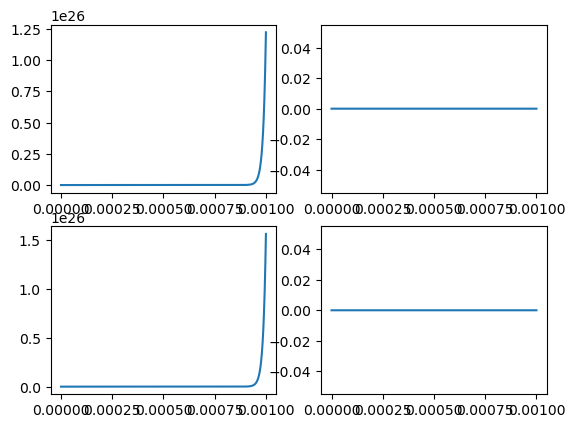

In [6]:
from TidalPy.radial_solver.numerical.derivatives.odes import dynamic_liquid_ode

from scipy.integrate import solve_ivp

rtol_const = 1.0e-9
atol_const = 1.0e-10
y0 = solutions[0]

out_cy_HighRes = cyrk_ode(
        dynamic_liquid_ode_cy,
        (radius_prime[0], radius_prime[-1]),
        y0,
        args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False),
        rtol=rtol_const, atol=atol_const,
        rk_method=1)


print('High Res')
print(out_cy_HighRes[2])
print(out_cy_HighRes[3])
print(out_cy_HighRes[0].shape)
print(out_cy_HighRes[1].shape)

plot_ys(out_cy_HighRes[0], out_cy_HighRes[1])

CyODE_LowRes
23.9 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
True
Integration completed without issue.
(686,)
(8, 686)


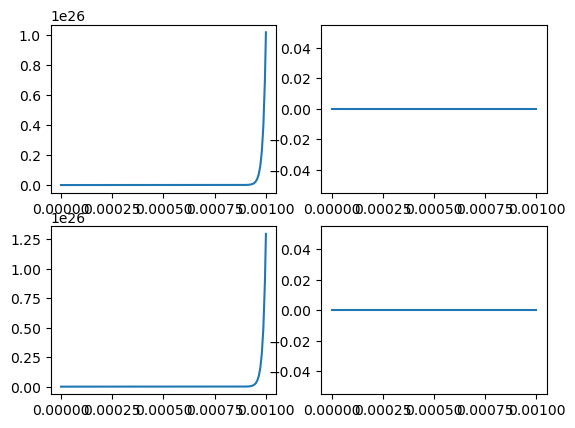



SciPy_LowRes
85.4 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
True
(672,)
(8, 672)


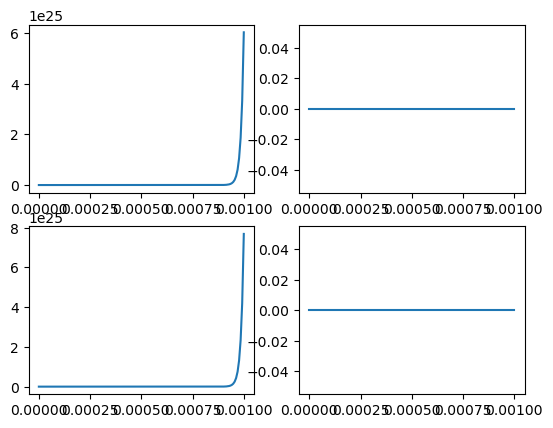

In [7]:
rtols = 1.0e-5 * np.ones(solutions[0].size, dtype=np.float64, order='C')
rtols[2] = 1.0e-6

print('CyODE_LowRes')
out_cyODE_LowRes = cyrk_ode(dynamic_liquid_ode_cy, t_span, y0, args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False), rtol=rtol_const, atol=atol_const, rtols=rtols, rk_method=1)
%timeit cyrk_ode(dynamic_liquid_ode_cy, t_span, y0, args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False), rtol=rtol_const, atol=atol_const, rtols=rtols, rk_method=1)
print(out_cyODE_LowRes[2])
print(out_cyODE_LowRes[3])
print(out_cyODE_LowRes[0].shape)
print(out_cyODE_LowRes[1].shape)
plot_ys(out_cyODE_LowRes[0], out_cyODE_LowRes[1])

print('\n\nSciPy_LowRes')
sol = solve_ivp(dynamic_liquid_ode, t_span, y0, method='RK45', rtol=rtols, atol=atol_const, args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False))
%timeit solve_ivp(dynamic_liquid_ode, t_span, y0, method='RK45', rtol=rtols, atol=atol_const, args=(radius_prime, bulk_modulus_prime, density_prime, gravity_prime, frequency_prime, order_l, newton_g_prime, False))
print(sol.success)
print(sol.t.shape)
print(sol.y.shape)

plot_ys(sol.t, sol.y)

CySolver
620 µs ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
True
Integration completed without issue.
(686,)
(8, 686)


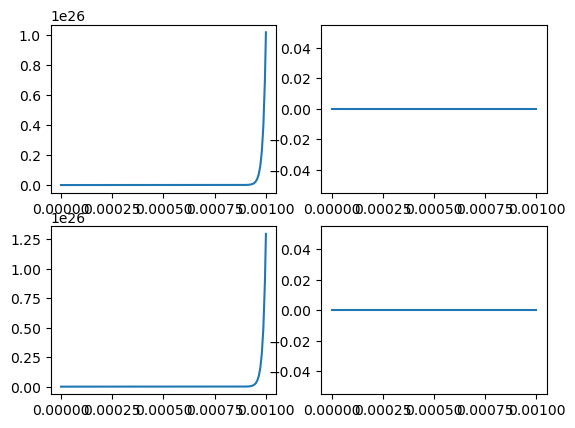

In [8]:
from TidalPy.radial_solver.numerical.derivatives.odes_x import LiquidDynamicCompressible

print('CySolver')
SolverInst = LiquidDynamicCompressible(radius_prime, density_prime, gravity_prime, shear_modulus_prime, bulk_modulus_prime, frequency_prime, order_l, newton_g_prime, t_span=t_span, y0=y0, rtol=rtol_const, atol=atol_const, rtols=rtols, atols=None, max_num_steps=1_000_000, expected_size=2000, rk_method=1, auto_solve=True, limit_solution_to_radius=False)
%timeit LiquidDynamicCompressible(radius_prime, density_prime, gravity_prime, shear_modulus_prime, bulk_modulus_prime, frequency_prime, order_l, newton_g_prime, t_span=t_span, y0=y0, rtol=rtol_const, atol=atol_const, rtols=rtols, atols=None, max_num_steps=1_000_000, expected_size=2000, rk_method=1, auto_solve=True, limit_solution_to_radius=False)
print(SolverInst.success)
print(SolverInst.message)
print(SolverInst.t.shape)
print(SolverInst.y.shape)

plot_ys(SolverInst.t, SolverInst.y)

In [10]:
for i in range(out_cy_HighRes[1].shape[0]):
    print()
    print('y', i)
    print(out_cy_HighRes[1][i, -1])
    print('cyODE_lowRes', out_cyODE_LowRes[1][i, -1], 100 * np.abs(out_cy_HighRes[1][i, -1] - out_cyODE_LowRes[1][i, -1])/out_cy_HighRes[1][i, -1])
    print('SciPy_LowRes', sol.y[i, -1], 100 * np.abs(out_cy_HighRes[1][i, -1] - sol.y[i, -1])/out_cy_HighRes[1][i, -1])
    print('CySolver', SolverInst.y[i, -1], 100 * np.abs(out_cy_HighRes[1][i, -1] - SolverInst.y[i, -1])/out_cy_HighRes[1][i, -1])


y 0
1.2224677264193758e+26
cyODE_lowRes 1.017478976890538e+26 16.768438552504982
SciPy_LowRes 6.029988245563009e+25 50.67364057761325
CySolver 1.017478976890538e+26 16.768438552504982

y 1
0.0
cyODE_lowRes 0.0 nan
SciPy_LowRes 0.0 nan
CySolver 0.0 nan

y 2
1.55795833070395e+26
cyODE_lowRes 1.2967131179546517e+26 16.768433892019242
SciPy_LowRes 7.684842182753605e+25 50.67363464540624
CySolver 1.2967131179546517e+26 16.768433892019242

y 3
0.0
cyODE_lowRes 0.0 nan
SciPy_LowRes 0.0 nan
CySolver 0.0 nan

y 4
2.6780169278237458e+23
cyODE_lowRes 2.2289651899323846e+23 16.76806943323831
SciPy_LowRes 1.3209766971575982e+23 50.673325346338565
CySolver 2.2289651899323846e+23 16.76806943323831

y 5
0.0
cyODE_lowRes 0.0 nan
SciPy_LowRes 0.0 nan
CySolver 0.0 nan

y 6
-4.676562194601242e+26
cyODE_lowRes -3.892375963574965e+26 -16.76843369968573
SciPy_LowRes -2.3067781619866645e+26 -50.67363447770083
CySolver -3.892375963574965e+26 -16.76843369968573

y 7
0.0
cyODE_lowRes 0.0 nan
SciPy_LowRes 0.0 na

## Radial Solver Function


In [16]:
%%cython --annotate --force
# distutils: language = c++
from cpython.mem cimport PyMem_Malloc, PyMem_Realloc, PyMem_Free

cdef Py_ssize_t N, test, i
N = 4
test = 3

cdef double complex** arr = <double complex**>PyMem_Malloc(test * sizeof(double complex*))
cdef double complex* arr_sub

for i in range(test):
    arr_sub = <double complex*> PyMem_Malloc(N * sizeof(double complex))
    for j in range(N):
        arr_sub[j] = j**i - 1.0j * i**2
    arr[i] = arr_sub

    print(arr[i][2])

cdef double complex*** solution_by_layer_solution_y = \
        <double complex***> PyMem_Malloc(3 * sizeof(double complex**))
    
for i in range(test):
    PyMem_Free(arr[i])
PyMem_Free(arr)
PyMem_Free(solution_by_layer_solution_y)

Content of stdout:
_cython_magic_661a63d49935e43af070c03a3c91fddbc3fc69db.cpp
C:\Users\joepr\.ipython\cython\_cython_magic_661a63d49935e43af070c03a3c91fddbc3fc69db.cpp(2530): warning C4244: 'argument': conversion from 'Py_ssize_t' to 'double', possible loss of data
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_661a63d49935e43af070c03a3c91fddbc3fc69db.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_661a63d49935e43af070c03a3c91fddbc3fc69db.cp311-win_amd64.exp
Generating code
Finished generating code(1+0j)
(2-1j)
(4-4j)


In [31]:
from numba import njit
import numpy as np
from scipy.special import gamma

@njit
def calc_andrade_shear_nb(frequency, shear, viscosity, alpha=.3, zeta=1.):

    maxwell_time = viscosity / shear
    const_term = (maxwell_time * zeta * frequency)**(alpha)

    denom = maxwell_time * gamma(alpha + 1.) * frequency * np.exp(-1j * alpha * np.pi / 2) + \
            maxwell_time * frequency * const_term - \
            1j * const_term

    return viscosity * frequency * const_term / denom

In [121]:
%%cython --annotate --force --compile-args=/openmp
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
from libc.math cimport fabs, cos, sin, pi, tgamma, NAN
from libcpp cimport bool as bool_cpp_t

from cython.parallel import prange

import logging
# from TidalPy.utilities.classes.base_x cimport TidalPyBaseExtensionClass

log = logging.getLogger(__name__)

cdef class RheologyModel():

    cdef Py_ssize_t num_args
    cdef Py_ssize_t expected_num_args
    cdef bool_cpp_t args_needed
    cdef bool_cpp_t debug_mode


    def __init__(
            self,
            tuple args = None,
            Py_ssize_t expected_num_args = 0,
            str class_name = 'RheologyModel',
            **kwargs):

        # Setup base class
#         super().__init__(class_name=class_name, **kwargs)

        # Define model specific parameters
        self.expected_num_args = expected_num_args
        self.debug_mode = False

        # Determine if additional arguments are needed for this model.
        if args is None:
            self.args_needed = False
        else:
            self.args_needed = True

        if self.args_needed:
            self.change_args(args)


    def change_args(self, tuple new_args):
        """ Change constant arguments for rheology model.

        Parameters
        ----------
        new_args : tuple[float, ...]
            A tuple of floats that are required by certain rheology models. If none are provided then defaults will be
            used.
        """

        cdef Py_ssize_t num_args
        num_args = len(new_args)

        if self.debug_mode:
            logging.debug(f'{self}: Additional arguments were changed.')
        if num_args != self.expected_num_args:
            logging.error(f'{self}: Unsupported number of arguments provided.')
            raise AttributeError(f'Unsupported number of arguments provided to {self}.')

        # Add args to any constant parameter references.
        # Since this is a base class; there are no additional arguments so nothing happens here.
        # But this will be overridden by the subclass for models that do require additional parameters.


    cdef double complex _implementation(
            self,
            double frequency,
            double modulus,
            double viscosity) noexcept nogil:

        cdef double complex out
        out = NAN + 1.0j * NAN
        return out


    cdef void _vectorize_frequency(
            self,
            double* frequency_ptr,
            double modulus,
            double viscosity,
            double complex* output_ptr,
            Py_ssize_t n,
            ) noexcept nogil:

        cdef Py_ssize_t i

        for i in prange(n):
            output_ptr[i] = self._implementation(frequency_ptr[i], modulus, viscosity)


    cdef void _vectorize_modulus_viscosity(
            self,
            double frequency,
            double* modulus_ptr,
            double* viscosity_ptr,
            double complex* output_ptr,
            Py_ssize_t n,
            ) noexcept nogil:

        cdef Py_ssize_t i

        for i in prange(n):
            output_ptr[i] = self._implementation(frequency, modulus_ptr[i], viscosity_ptr[i])


    def vectorize_frequency(
            self,
            double[:] frequency_view,
            double modulus,
            double viscosity,
            double complex[:] output_view,
            ):
        
        cdef Py_ssize_t n
        n = len(frequency_view)
        
        self._vectorize_frequency(&frequency_view[0], modulus, viscosity, &output_view[0], n)
    
    
    def vectorize_modulus_viscosity(
            self,
            double frequency,
            double[:] modulus_view,
            double[:] viscosity_view,
            double complex[:] output_view,
            ):

        cdef Py_ssize_t n
        n = len(modulus_view)

        self._vectorize_modulus_viscosity(frequency, &modulus_view[0], &viscosity_view[0], &output_view[0], n)


    def __call__(
            self,
            double frequency,
            double modulus,
            double viscosity):

        cdef double complex out
        out = self._implementation(frequency, modulus, viscosity)

        return out


########################################################################################################################
######################################## New Rheological Models Go Below Here! #########################################
########################################################################################################################


cdef class AndradeRheology(RheologyModel):

    cdef double alpha
    cdef double alpha_factorial
    cdef double zeta
    cdef double complex sine_term

    def __init__(self, tuple args=(0.3, 1.0), **kwargs):
        super().__init__(args=args, expected_num_args=2, class_name='AndradeRheology')


    def change_args(self, tuple new_args):

        super().change_args(new_args)

        # Add args to any constant parameter references.
        # Since this is a base class; there are no additional arguments so nothing happens here.
        # But this will be overridden by the subclass for models that do require additional parameters.
        self.alpha = new_args[0]
        self.zeta  = new_args[1]
        self.alpha_factorial = tgamma(self.alpha + 1.)
        self.sine_term = cos(pi * self.alpha / 2.) - 1.0j * sin(pi * self.alpha / 2.)

    cdef double complex _implementation(
            self,
            double frequency,
            double shear,
            double viscosity) noexcept nogil:

        cdef double maxwell_time = viscosity / shear
        cdef double max_freq = maxwell_time * frequency
        cdef double const_term   = (max_freq * self.zeta)**(self.alpha)

        cdef double complex denom
        denom = max_freq * self.alpha_factorial * self.sine_term + \
                max_freq * const_term - \
                1j * const_term

        cdef double complex out
        out = (viscosity * frequency * const_term) / denom

        return out

Content of stdout:
_cython_magic_6abea94cb6d0d3da42ce71f5d10c403742f7497e.cpp
C:\Users\joepr\.ipython\cython\_cython_magic_6abea94cb6d0d3da42ce71f5d10c403742f7497e.cpp(26416): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_6abea94cb6d0d3da42ce71f5d10c403742f7497e.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_6abea94cb6d0d3da42ce71f5d10c403742f7497e.cp311-win_amd64.exp
Generating code
Finished generating code

In [122]:
freq = 1.0e-5
visco = 1.0e18
shear = 50.0e9
shears = np.ones(1000, dtype=np.float64)
viscos = np.ones(1000, dtype=np.float64)

# 11.7us
# 11.3us
output = np.empty(1000, dtype=np.complex128)
inst = AndradeRheology()
%timeit inst.vectorize_modulus_viscosity(freq, shears, viscos, output)

# 620ns, 629ns
print(calc_andrade_shear_nb(freq, shear, visco, alpha=.3, zeta=1.))
%timeit calc_andrade_shear_nb(freq, shear, visco, alpha=.3, zeta=1.)
# 68.5us
%timeit calc_andrade_shear_nb(freq, shear, visco)


# 173 ns
inst = AndradeRheology()
print(inst(freq, shear, visco))
%timeit inst(freq, shear, visco)

calc_andrade_shear_nb(freq, shears, viscos, alpha=.3, zeta=1.)
# 37.1us, 37.3us
%timeit calc_andrade_shear_nb(freq, shears, viscos, alpha=.3, zeta=1.)
# 169us
%timeit calc_andrade_shear_nb(freq, shears, viscos)

def f():
    out = np.empty(1000, dtype=np.complex128)
    for i in range(1000):
        out[i] = inst(freq, shears[i], viscos[i])
    return out

# 548us, 539us
%timeit f()

# 192us, 193us
inst_v = np.vectorize(inst)
%timeit inst_v(freq, shears, viscos)

# 54.1us, 54.3us
output = np.empty(1000, dtype=np.complex128)
%timeit inst.radial_array(freq, shears, viscos, output)
        
    

11.3 µs ± 340 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
(42741275848.59761+3238434084.1857285j)
644 ns ± 1.59 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
68.3 µs ± 353 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
(42741275848.59761+3238434084.185728j)
174 ns ± 0.16 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
37.3 µs ± 546 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
144 µs ± 236 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
543 µs ± 638 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
198 µs ± 2.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


AttributeError: '_cython_magic_6abea94cb6d0d3da42ce71f5d10c403742f7' object has no attribute 'radial_array'

275 µs ± 970 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
275 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.23 ms ± 91.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.19 ms ± 39.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [49]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from libcpp cimport bool as bool_cpp_t
from libc.math cimport fabs, cos, sin, pi, tgamma, NAN

cpdef double complex calc_andrade_shear_cy(double frequency, double shear, double viscosity,
                                        double alpha = 0.3, double zeta = 1.):

    cdef double maxwell_time = viscosity / shear
    cdef double const_term   = (maxwell_time * zeta * frequency)**(alpha)
    cdef double sine_inner   = pi * alpha / 2. 

    cdef double complex denom
    denom = maxwell_time * tgamma(alpha + 1.) * frequency * (cos(sine_inner) - 1.0j * sin(sine_inner)) + \
            maxwell_time * frequency * const_term - \
            1j * const_term
    
    cdef double complex out
    out = (viscosity * frequency * const_term) / denom
    
    return out


from cpython.mem cimport PyMem_Malloc, PyMem_Realloc, PyMem_Free

cdef class RheologyModel:
    
    cdef Py_ssize_t num_args
    cdef double* args_ptr
    cdef bool_cpp_t args_needed
    
    def __init__(self, tuple args=None):
    
        if args is None:
            self.args_needed = False
            self.num_args    = 1
        else:
            self.args_needed = True
            self.num_args    = len(args)
        
        self.args_ptr = <double *> PyMem_Malloc(self.num_args * sizeof(double))
        if not self.args_ptr:
            raise MemoryError()
            
        # Load arguments into pointer
        cdef Py_ssize_t i
        for i in range(self.num_args):
            self.args_ptr[i] = args[i]
        
        if self.args_needed:
            self.args_changed()
            
    cdef void args_changed(self) noexcept nogil:
        
        pass
        
    
    cdef double complex _implementation(
            self, 
            double frequency,
            double shear,
            double viscosity) noexcept nogil:
        
        cdef double complex out
        out = NAN + 1.0j * NAN
        return out
    
    def __call__(
            self, 
            double frequency,
            double shear,
            double viscosity):
        
        cdef double complex out
        out = self._implementation(frequency, shear, viscosity)
        
        return out
    
    def __dealloc__(self):
        PyMem_Free(self.args_ptr)

cdef class Andrade(RheologyModel):
    
    cdef double alpha
    cdef double alpha_factorial
    cdef double zeta
    cdef double complex sine_term
    
    def __init__(self, tuple args=None):
        
        if args is None:
            # Use defaults
            super().__init__(args=(0.3, 1.0))
        else:
            if len(args) != 2:
                raise AttributeError('Unexpected number of args.')
            super().__init__(args=args)
    
    cdef void args_changed(self) noexcept nogil:
        
        self.alpha = self.args_ptr[0]
        self.zeta  = self.args_ptr[1]
        self.alpha_factorial = tgamma(self.alpha + 1.)
        self.sine_term = cos(pi * self.alpha / 2.) - 1.0j * sin(pi * self.alpha / 2.)

    cdef double complex _implementation(
            self, 
            double frequency,
            double shear,
            double viscosity) noexcept nogil:
        
        cdef double maxwell_time = viscosity / shear
        cdef double max_freq = maxwell_time * frequency
        cdef double const_term   = (max_freq * self.zeta)**(self.alpha)

        cdef double complex denom
        denom = max_freq * self.alpha_factorial * self.sine_term + \
                max_freq * const_term - \
                1j * const_term

        cdef double complex out
        out = (viscosity * frequency * const_term) / denom

        return out
        

Content of stdout:
_cython_magic_54dfe354d016f8505ca1c313d6529c18061a3f2e.cpp
C:\Users\joepr\.ipython\cython\_cython_magic_54dfe354d016f8505ca1c313d6529c18061a3f2e.cpp(6320): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_54dfe354d016f8505ca1c313d6529c18061a3f2e.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_54dfe354d016f8505ca1c313d6529c18061a3f2e.cp311-win_amd64.exp
Generating code
Finished generating code

In [50]:
freq = 1.0e-5
visco = 1.0e18
shear = 50.0e9

print('\nNumba')
# 70.4us 68us
print(calc_andrade_shear_nb(freq, shear, visco))
%timeit calc_andrade_shear_nb(freq, shear, visco)

print('\nCython Func')
# 197ns 189ns 191ns
print(calc_andrade_shear_cy(freq, shear, visco))
%timeit calc_andrade_shear_cy(freq, shear, visco)

print('\nCython Class')
# Build 632ns; 630ns
# Run 187ns; 187ns
# Build & Run 819ns; 817ns
AInst = Andrade()
print(AInst(freq, shear, visco))
%timeit Andrade()
%timeit AInst(freq, shear, visco)
%timeit Andrade()(freq, shear, visco)


Numba
(42741275848.59761+3238434084.1857285j)
68.3 µs ± 273 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

Cython Func
(42741275848.59761+3238434084.185728j)
190 ns ± 0.749 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)

Cython Class
(42741275848.59761+3238434084.185728j)
591 ns ± 0.912 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
187 ns ± 1.08 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
795 ns ± 11.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [13]:
%%cython --annotate --force
# distutils: language = c++

from libcpp cimport bool as bool_cpp_t
from libc.math cimport NAN, fmax

from cpython.mem cimport PyMem_Malloc, PyMem_Realloc, PyMem_Free

import numpy as np
cimport numpy as np

from scipy.constants import G as G_
from TidalPy.radial_solver.numerical.collapse import collapse_solutions
from TidalPy.radial_solver.numerical.initial import find_initial_guess
from TidalPy.radial_solver.numerical.interfaces import find_interface_func

# Import cythonized functions
from TidalPy.radial_solver.nondimensional_x cimport  non_dimensionalize_physicals_x
from TidalPy.radial_solver.numerical.interfaces.interfaces_x cimport find_solution_num
from TidalPy.radial_solver.numerical.derivatives.ode_base_x cimport RadialSolverBase
from TidalPy.radial_solver.numerical.derivatives.odes_x cimport build_solver

def non_dimensionalize_physicals(
    radius: 'FloatArray', gravity: 'FloatArray', density: 'FloatArray',
    shear_modulus: 'NumArray', bulk_modulus: 'NumArray', frequency: 'FloatArray',
    mean_radius: float, bulk_density: float
    ):
    """ A function to non-dimensionalize physical parameters

    Parameters
    ----------
    radius : FloatArray
        Radius of the planet (usually an array) [m]
    gravity : FloatArray
        Acceleration due to gravity of the planet (usually an array) [m s-2]
    density : FloatArray
        Density of the planet (usually an array) [kg m-3]
    shear_modulus : NumArray
        Shear modulus of the planet (usually an array, can be complex) [Pa]
    bulk_modulus : NumArray
        Bulk modulus of the planet (usually an array, can be complex) [Pa]
    frequency : FloatArray
        Forcing frequency of the tidal forces [rad s-1]
    mean_radius : float
        Mean radius of the planet, used in scaling [m]
    bulk_density : float
        Bulk density of the planet, used in scaling [m]

    Returns
    -------
    radius_prime : FloatArray
        Non-dimensional radius of the planet
    gravity_prime : FloatArray
        Non-dimensional Acceleration due to gravity of the planet
    density_prime : FloatArray
        Non-dimensional Density of the planet
    shear_modulus_prime : NumArray
        Non-dimensional Shear modulus of the planet
    bulk_modulus_prime : NumArray
        Non-dimensional Bulk modulus of the planet
    frequency_prime : FloatArray
        Non-dimensional forcing frequency of the tidal forces
    newton_g_prime : float
        Non-dimensional Newton's gravitational constant

    See Also
    --------
    nondimensional.re_dimensionalize_physicals

    """

    # Setup conversions
    second2_conversion = 1. / (np.pi * G * bulk_density)
    second_conversion = np.sqrt(second2_conversion)
    length_conversion = mean_radius
    density_conversion = bulk_density
    mass_conversion = bulk_density * mean_radius**3
    pascal_conversion = mass_conversion / (length_conversion * second2_conversion)

    # Convert variables
    radius_prime = radius / length_conversion
    density_prime = density / density_conversion
    gravity_prime = gravity / (length_conversion / second2_conversion)
    shear_modulus_prime = shear_modulus / pascal_conversion
    bulk_modulus_prime = bulk_modulus / pascal_conversion
    frequency_prime = frequency / (1. / second_conversion)

    # Calculations will also need the universal gravitational constant to be non-dim
    newton_g_prime = G / (length_conversion**3 / (mass_conversion * second2_conversion))

    return radius_prime, gravity_prime, density_prime, shear_modulus_prime, bulk_modulus_prime, frequency_prime, \
           newton_g_prime


# Setup globals
cdef double G
G = G_

cdef Py_ssize_t MAX_NUM_SOLS    = 3
cdef Py_ssize_t MAX_NUM_YS      = 6
cdef Py_ssize_t MAX_NUM_YS_REAL = 2 * MAX_NUM_YS

def radial_solver_x(
        double[:] radius_array,
        double[:] density_array,
        double[:] gravity_array,
        double[:] bulk_modulus_array,
        double[:] shear_modulus_array,
        double[:] viscosity_array,
        double frequency,
        double planet_bulk_density,
        tuple is_solid_by_layer,
        tuple is_static_by_layer,
        tuple is_incompressible_by_layer,
        tuple upper_radius_by_layer,
        unsigned int degree_l = 2,
        double complex[:] surface_boundary_conditions = None,
        bool_cpp_t solve_load_numbers = False,
        bool_cpp_t use_kamata = False,
        int integration_method = 1,
        double integration_rtol = 1.0e-4,
        double integration_atol = 1.0e-12,
        bool_cpp_t scale_rtols_by_layer_ptr_type = True,
        Py_ssize_t max_num_steps = 500_000,
        Py_ssize_t expected_size = 850,
        double max_step = 0,
        bool_cpp_t limit_solution_to_radius = True,
        bool_cpp_t verbose = False,
        bool_cpp_t nondimensionalize = True,
        ):
    # General indexing
    cdef Py_ssize_t i, j, k, m

    # Pull out key information
    cdef double radius_planet
    cdef Py_ssize_t num_layers, num_interfaces, num_radius

    num_radius     = len(radius_array)
    radius_planet  = radius_array[num_radius - 1]
    num_layers     = len(is_solid_by_layer)
    num_interfaces = num_layers - 1
    if num_layers <= 0:
        raise AttributeError('Radial solver requires at least one layer.')

    # Non-dimensionalize inputs
    cdef double G_to_use
    
    # Build main input pointers
    cdef double* radius_array_ptr = <double *> PyMem_Malloc(num_radius * sizeof(double))
    if not radius_array_ptr:
        raise MemoryError()
        
    cdef double* density_array_ptr = <double *> PyMem_Malloc(num_radius * sizeof(double))
    if not density_array_ptr:
        raise MemoryError()
        
    cdef double* gravity_array_ptr = <double *> PyMem_Malloc(num_radius * sizeof(double))
    if not gravity_array_ptr:
        raise MemoryError()
        
    cdef double* bulk_array_ptr = <double *> PyMem_Malloc(num_radius * sizeof(double))
    if not bulk_array_ptr:
        raise MemoryError()
        
    cdef double* shear_array_ptr = <double *> PyMem_Malloc(num_radius * sizeof(double complex))
    if not shear_array_ptr:
        raise MemoryError()
    
    cdef double* viscosity_array_ptr = <double *> PyMem_Malloc(num_radius * sizeof(double complex))
    if not viscosity_array_ptr:
        raise MemoryError()

    if nondimensionalize:
        non_dimensionalize_physicals_x(
            num_radius,
            radius_array_ptr,
            density_array_ptr,
            gravity_array_ptr,
            bulk_array_ptr,
            shear_array_ptr,
            viscosity_array_ptr,
            &frequency,
            &G_to_use,
            radius_planet,
            planet_bulk_density
            )
    else:
        # Leave inputs alone. Store copy in new pointers.
        G_to_use = G
        for i in range(num_radius):
            radius_array_ptr[i]    = radius_array[i]
            density_array_ptr[i]   = density_array[i]
            gravity_array_ptr[i]   = gravity_array[i]
            bulk_array_ptr[i]      = bulk_array[i]
            shear_array_ptr[i]     = shear_array[i]
            viscosity_array_ptr[i] = viscosity_array[i]
            

    # Find boundary condition at the top of the planet -- this is dependent on the forcing type.
    #     Tides (default here) follow the (y2, y4, y6) = (0, 0, (2l+1)/R) rule
    cdef np.ndarray[np.complex128_t, ndim=1] bc_array
    cdef double complex[::1] bc_array_view
    bc_array = np.empty(3, dtype=np.complex128, order='C')
    bc_array_view = bc_array

    if surface_boundary_conditions is None:
        # Assume tides
        for i in range(3):
            if i == 2:
                if nondimensionalize:
                    bc_array_view[i] == (2. * degree_l + 1.) / 1.
                else:
                    bc_array_view[i] == (2. * degree_l + 1.) / radius_planet
    else:
        # Use user input
        if len(surface_boundary_conditions) != 3:
            raise AttributeError('Unexpected number of user-provided surface boundary conditions.')
        for i in range(3):
            bc_array_view[i] = surface_boundary_conditions[i]

    # Integration information
    # Max step size
    cdef double max_step_touse
    cdef bool_cpp_t max_step_from_arrays
    max_step_from_arrays = False
    if max_step == 0:
        # If max_step is zero use the array information to determine max_step_size
        max_step_from_arrays = True
    else:
        # Otherwise use user input.
        max_step_touse = max_step

    # Tolerances
    cdef double* rtols_by_layer_ptr = <double *> PyMem_Malloc(num_layers * MAX_NUM_YS_REAL * sizeof(double))
    if not rtols_by_layer_ptr:
        raise MemoryError()

    cdef double* atols_by_layer_ptr = <double *> PyMem_Malloc(num_layers * MAX_NUM_YS_REAL * sizeof(double))
    if not atols_by_layer_ptr:
        raise MemoryError()

    # Find number of solutions per layer
    cdef Py_ssize_t* num_solutions_by_layer_ptr = \
        <Py_ssize_t*> PyMem_Malloc(num_layers * sizeof(Py_ssize_t))
    if not num_solutions_by_layer_ptr:
        raise MemoryError()

    cdef Py_ssize_t* start_index_by_layer_ptr = \
        <Py_ssize_t*> PyMem_Malloc(num_layers * sizeof(Py_ssize_t))
    if not start_index_by_layer_ptr:
        raise MemoryError()

    cdef Py_ssize_t* num_slices_by_layer_ptr = \
        <Py_ssize_t*> PyMem_Malloc(num_layers * sizeof(Py_ssize_t))
    if not num_slices_by_layer_ptr:
        raise MemoryError()

    cdef bool_cpp_t layer_is_solid, layer_is_static, layer_is_incomp
    cdef bool_cpp_t layer_below_is_solid, layer_below_is_static, layer_below_is_incomp
    cdef double layer_upper_radius, radius_check
    cdef Py_ssize_t num_slices, num_sols, num_ys, max_slices

    # Track the largest number of slices in a layer.
    # Used to more efficiently allocate memory for other storage arrays
    max_slices = -1

    for i in range(num_layers):
        # Pull out information on this layer
        layer_is_solid     = is_solid_by_layer[i]
        layer_is_static    = is_static_by_layer[i]
        layer_is_incomp    = is_incompressible_by_layer[i]
        layer_upper_radius = upper_radius_by_layer[i]

        # Find number of solutions based on this layer's assumptions
        num_sols = <Py_ssize_t>find_solution_num(
            layer_is_solid,
            layer_is_static,
            layer_is_incomp
            )
        num_ys = 2 * num_sols
        num_solutions_by_layer_ptr[i] = num_sols

        # Scale rtols by layer type
        for j in range(num_ys):
            atols_by_layer_ptr[i * MAX_NUM_YS_REAL + j] = integration_atol
            # TODO test that these scales are the best.
            if scale_rtols_by_layer_ptr_type:
                if layer_is_solid:
                    # Scale (real and imag) y2 (index 2, 3) and y3 (index 4, 5) by 0.1
                    if (j >= 2) and (j <= 5):
                        rtols_by_layer_ptr[i * MAX_NUM_YS_REAL + j] = integration_rtol * 0.1
                    else:
                        rtols_by_layer_ptr[i * MAX_NUM_YS_REAL + j] = integration_rtol
                else:
                    if layer_is_static:
                        # Don't scale
                        rtols_by_layer_ptr[i * MAX_NUM_YS_REAL + j] = integration_rtol
                    else:
                        # Scale (real and imag) y2 by 0.01
                        if (j == 2) or (j == 3):
                            rtols_by_layer_ptr[i * MAX_NUM_YS_REAL + j] = integration_rtol * 0.01
                        else:
                            rtols_by_layer_ptr[i * MAX_NUM_YS_REAL + j] = integration_rtol

        # Determine how many slices are in this layer
        if i == 0:
            # First layer starts at 0.
            start_index_by_layer_ptr[0] = 0
        else:
            # Not first layer. Starting point is based on number of slices in previous layer.
            start_index_by_layer_ptr[i] = start_index_by_layer_ptr[i - 1] + num_slices_by_layer_ptr[i - 1]

        num_slices = 0
        for j in range(start_index_by_layer_ptr[i], num_radius):
            radius_check = radius_array[j]
            if radius_check > layer_upper_radius:
                # We have passed this layer.
                break
            num_slices += 1
        num_slices_by_layer_ptr[i] = num_slices
        if max_slices < num_slices:
            max_slices = num_slices

    # We have all the size information needed to build storage pointers
    # Main storage pointer is setup like [layer_i][solution_i][y_i + r_i]
    cdef double complex*** main_storage = <double complex ***> PyMem_Malloc(num_layers * sizeof(double complex**))
    if not main_storage:
        raise MemoryError()

    cdef double complex** storage_by_solution
    cdef double complex* storage_by_y

    for i in range(num_layers):
        num_sols   = num_solutions_by_layer_ptr[i]
        num_slices = num_slices_by_layer_ptr[i]
        # Number of ys = 2x num sols
        num_ys = 2 * num_sols

        storage_by_solution = <double complex**> PyMem_Malloc(num_sols * sizeof(double complex*))
        if not storage_by_solution:
            raise MemoryError()

        for j in range(num_sols):
            storage_by_y = <double complex*> PyMem_Malloc(num_slices * num_ys * sizeof(double complex))
            if not storage_by_y:
                raise MemoryError()

            storage_by_solution[j] = storage_by_y
        main_storage[i] = storage_by_solution

    # Storage for solutions at the top of a layer.
    cdef double complex[:, :] last_layer_top_solutions_view

    # Interface information
    cdef object interface_func
    cdef tuple interface_inputs

    # Layer specific pointers; set the size based on the layer with the most slices.
    cdef double* layer_radius_ptr
    cdef double* layer_density_ptr
    cdef double* layer_gravity_ptr
    cdef double* layer_bulk_mod_ptr
    cdef double complex* layer_shear_mod_ptr
    cdef double* layer_rtols_ptr
    cdef double* layer_atols_ptr

    # Properties at top and bottom of layer
    cdef double radius_lower, radius_upper
    cdef double density_lower, density_upper
    cdef double gravity_lower, gravity_upper
    cdef double bulk_lower
    cdef double complex shear_lower
    cdef tuple radial_span

    # Properties at interfaces between layers
    cdef double static_liquid_density
    cdef double interface_gravity

    # Starting solutions (initial conditions / lower boundary conditions)
    cdef double complex[:, ::1] initial_solutions_view
    cdef double[:, ::1] initial_solutions_real_view

    # Solver class
    cdef RadialSolverBase solver

    # Feedback
    cdef str feedback_str
    feedback_str = ''
    cdef bool_cpp_t error
    error = False

    cdef Py_ssize_t start_index, end_index
    for i in range(num_layers):
        # Get layer's index information
        start_index = start_index_by_layer_ptr[i]
        num_slices  = num_slices_by_layer_ptr[i]
        end_index   = start_index + num_slices

        # Get solution and y information
        num_sols = num_solutions_by_layer_ptr[i]
        num_ys   = 2 * num_sols

        # Setup pointer array slices
        layer_radius_ptr    = &radius_array[start_index]
        layer_density_ptr   = &density_array[start_index]
        layer_gravity_ptr   = &gravity_array[start_index]
        layer_bulk_mod_ptr  = &bulk_modulus_array[start_index]
        layer_shear_mod_ptr = &complex_shear_modulus_array[start_index]

        # Setup other pointers
        layer_rtols_ptr = &rtols_by_layer_ptr[i * MAX_NUM_YS_REAL]
        layer_atols_ptr = &atols_by_layer_ptr[i * MAX_NUM_YS_REAL]

        # Get physical parameters at the top and bottom of the layer
        radius_lower  = layer_radius_ptr[0]
        density_lower = layer_density_ptr[0]
        gravity_lower = layer_gravity_ptr[0]
        bulk_lower    = layer_bulk_mod_ptr[0]
        shear_lower   = layer_shear_mod_ptr[0]
        radius_upper  = layer_radius_ptr[num_slices - 1]
        density_upper = layer_density_ptr[num_slices - 1]
        gravity_upper = layer_gravity_ptr[num_slices - 1]

        # Determine max step size (if not provided by user)
        if max_step_from_arrays:
            # Maximum step size during integration can not exceed the average radial slice size.
            max_step_touse = (radius_upper - radius_lower) / <double>num_slices

        # Get assumptions for layer
        layer_is_solid  = is_solid_by_layer[i]
        layer_is_static = is_static_by_layer[i]
        layer_is_incomp = is_incompressible_by_layer[i]

        # Find initial conditions for each solution at the base of this layer.
        radial_span = (radius_lower, radius_upper)
        if i == 0:
            # Use initial condition function
            initial_solutions_view = find_initial_guess(
                layer_is_solid,
                layer_is_static,
                layer_is_incomp,
                use_kamata,
                radius_lower,
                shear_lower,
                bulk_lower,
                density_lower,
                frequency,
                order_l=degree_l,
                G_to_use=G_to_use
                )
        else:
            layer_below_is_solid  = is_solid_by_layer[i - 1]
            layer_below_is_static = is_static_by_layer[i - 1]
            layer_below_is_incomp = is_incompressible_by_layer[i - 1]

            # Find gravity at the base interface using bottom of this layer and top of previous.
            interface_gravity = 0.5 * (gravity_lower + last_layer_upper_gravity)

            # Find the density needed for some initial conditions.
            if layer_is_solid and layer_below_is_solid:
                # Both layers are solid. A liquid interface density is not needed.
                static_liquid_density = NAN
            elif not layer_is_solid and layer_below_is_solid:
                # Layer below is solid, this layer is liquid. Use its density.
                static_liquid_density = density_lower
            elif layer_is_solid and not layer_below_is_solid:
                # Layer below is liquid, this layer is solid. Use layer below's density.
                static_liquid_density = last_layer_upper_density
            else:
                # Both layers are liquid. Choose the layer's density which is static.
                if layer_is_static and layer_below_is_static:
                    # Both layers are static.
                    # TODO: Not sure what to do here so just use this layer's density.
                    static_liquid_density = density_lower
                elif layer_is_static and not layer_below_is_static:
                    # This layer is static, one below is not. Use this layer's density
                    static_liquid_density = density_lower
                elif not layer_is_static and layer_below_is_static:
                    # This layer is dynamic, layer below is static. Use layer below's density
                    static_liquid_density = last_layer_upper_density
                else:
                    # Both layers are dynamic. Static liquid density is not needed.
                    static_liquid_density = NAN

            # Use results at the top of the layer below and a interface function
            interface_func, interface_inputs = find_interface_func(
                layer_below_is_solid,
                layer_below_is_static,
                layer_is_solid,
                layer_is_static,
                static_liquid_density,
                interface_gravity,
                G_to_use=G_to_use
                )

            # Run interface function
            initial_solutions_view = interface_func(
                last_layer_top_solutions_view
                *interface_inputs
                )

        # Change initial conditions into 2x real values instead of complex for integration
        # TODO: change to pointers
        initial_solutions_real_arr  = np.empty((num_sols, num_ys * 2), dtype=np.float64, order='C')
        initial_solutions_real_view = initial_solutions_real_arr
        for j in range(num_sols):
            for k in range(num_ys):
                initial_solutions_real_view[j, (2 * k)]     = np.real(initial_solutions_view[j, k])
                initial_solutions_real_view[j, (2 * k) + 1] = np.imag(initial_solutions_view[j, k])

        # Build solver instance
        solver = build_solver(
            layer_is_solid,
            layer_is_static,
            layer_is_incomp,
            num_slices,
            layer_radius_ptr,
            layer_density_ptr,
            layer_gravity_ptr,
            layer_bulk_mod_ptr,
            layer_shear_mod_ptr,
            frequency,
            degree_l,
            G_to_use,
            radial_span,
            initial_solutions_real_view[0, :],
            layer_rtols_ptr,
            layer_atols_ptr,
            integration_method,
            max_step_touse,
            max_num_steps,
            expected_size,
            limit_solution_to_radius
            )

        # Get storage pointer for this layer
        storage_by_solution = main_storage[i]

        # TODO: make this pointers
        last_layer_top_solutions_arr  = np.empty((num_sols, num_ys), dtype=np.complex128, order='C')
        last_layer_top_solutions_view = last_layer_top_solutions_arr

        # Solve for each solution
        for j in range(num_sols):

            if j > 0:
                # Reset solver with new initial condition (this is already done for j==0)
                solver.change_y0(initial_solutions_real_view[j, :], auto_reset_state=False)

            # Integrate!
            solver.solve(reset=True)

            # Check for problems
            if not solver.success:
                # Problem with integration.
                feedback_str = f'Integration problem at layer {i}; solution {j}:\n\t{solver.message}'
                error = True
                break

            # If no problems, store results.
            # Need to make a copy because the solver pointers will be reallocated during the next solution.
            # Get storage pointer for this solution
            storage_by_y = storage_by_solution[j]
            for m in range(num_slices):
                for k in range(num_ys):

                    # Convert 2x real ys to 1x complex ys
                    storage_by_y[m * num_ys + k] = \
                        (solver.solution_y_ptr[m * num_ys + (2 * k)] +
                         1.0j * solver.solution_y_ptr[m * num_ys + (2 * k) + 1])

                    # Store top most result for initial condition for the next layer
                    if m == (num_slices - 1):
                        last_layer_top_solutions_view[j, k] = storage_by_y[m * num_ys + k]

        if error:
            # Error was encountered during integration
            break

        # Prepare for next layer
        last_layer_upper_gravity = gravity_upper
        last_layer_upper_density = density_upper


    if not error:
        feedback_str = 'Integration completed for all layers.'




    # Release pointers
    PyMem_Free(num_solutions_by_layer_ptr)
    PyMem_Free(num_slices_by_layer_ptr)
    PyMem_Free(layer_radius_ptr)
    PyMem_Free(layer_density_ptr)
    PyMem_Free(layer_gravity_ptr)
    PyMem_Free(layer_bulk_mod_ptr)
    PyMem_Free(layer_shear_mod_ptr)
    PyMem_Free(rtols_by_layer_ptr)
    PyMem_Free(atols_by_layer_ptr)

    # Deconstruct main solution pointer
    # Main storage pointer is setup like [layer_i][solution_i][y_i + r_i]
    for i in range(num_layers):
        num_sols   = num_solutions_by_layer_ptr[i]
        num_slices = num_slices_by_layer_ptr[i]
        # Number of ys = 2x num sols
        num_ys = 2 * num_sols
        for j in range(num_sols):
            PyMem_Free(main_storage[i][j])
        PyMem_Free(main_storage[i])
    PyMem_Free(main_storage)





Content of stdout:
_cython_magic_e0319cc3c76d0ef5790a69b2fb7282c0302fc0aa.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_e0319cc3c76d0ef5790a69b2fb7282c0302fc0aa.cpp(31170): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_e0319cc3c76d0ef5790a69b2fb7282c0302fc0aa.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_e0319cc3c76d0ef5790a69b2fb7282c0302fc0aa.cp311-win_amd64.exp
Generating code
Finished generating code

In [14]:
import numpy as np

radius_array = np.linspace(0.1, 1000.e3, 10)
density_array = 3500. * np.ones_like(radius_array)
gravity_array = np.linspace(0.01, 9.0, 10)
bulk_modulus_array = 1.0e10 * np.ones_like(radius_array)
complex_shear_modulus_array = (1.0e10 + 1.0j * 1e3) * np.ones_like(radius_array)
frequency = 0.001
planet_bulk_density = 3500.
is_solid_by_layer = (True,)
is_static_by_layer = (True,)
is_incompressible_by_layer = (False,)
upper_radius_by_layer = (radius_array[-1],)

radial_solver_x(
    radius_array,
    density_array,
    gravity_array,
    bulk_modulus_array,
    complex_shear_modulus_array,
    frequency,
    planet_bulk_density,
    is_solid_by_layer,
    is_static_by_layer,
    is_incompressible_by_layer,
    upper_radius_by_layer,
    degree_l = 2,
    surface_boundary_conditions = None,
    solve_load_numbers = False,
    use_kamata = False,
    integration_method = 1,
    integration_rtol = 1.0e-4,
    integration_atol = 1.0e-12,
    scale_rtols_by_layer_ptr_type = True,
    max_num_steps = 500_000,
    expected_size = 850,
    max_step = 0,
    limit_solution_to_radius = True,
    verbose = False,
    nondimensionalize = True,
    )

TypeError: unsupported operand type(s) for /: '_cython_magic_e0319cc3c76d0ef5790a69b2fb7282c0302fc0aa._memoryviewslice' and 'float'

In [8]:
radius_array, gravity_array, density_array, complex_shear_array, bulk_array, frequency, G_to_use = \
            non_dimensionalize_physicals(
                    radius_array, gravity_array, density_array, complex_shear_modulus_array, bulk_modulus_array, frequency,
                    mean_radius=radius_array[-1], bulk_density=planet_bulk_density
                    )